In [1]:
import pandas as pd 
import  numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 
import  xml.etree.ElementTree as et 
import  cv2
import os 
import plotly.io as  px 
from glob import glob
from shutil import move,copy

In [2]:
from tensorflow.keras.preprocessing.image import  load_img,array_to_img,img_to_array
from sklearn.model_selection import  train_test_split

In [3]:
#  read the  annotatin file 
xml_path = glob('/kaggle/input/face-mask-detection/annotations/*.xml')
object_info = dict(filename =[],width=[],height=[],xmin =[],xmax=[],ymin=[],ymax=[],name=[])

for path in xml_path:
    
    parse = et.parse(path)
    root = parse.getroot()
    
    fname = root.find('filename').text
    
    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text
    object_all = root.findall('object')
    for obj in object_all:
        
        bbox_info = obj.find('bndbox')
        name = obj.find('name').text
        xmin = bbox_info.find('xmin').text
        xmax = bbox_info.find('xmax').text
        ymin = bbox_info.find('ymin').text
        ymax = bbox_info.find('ymax').text
        
        object_info['filename'].append(fname)
        object_info['width'].append(width)
        object_info['height'].append(height)
        object_info['xmin'].append(xmin)
        object_info['xmax'].append(xmax)
        object_info['ymin'].append(ymin)
        object_info['ymax'].append(ymax) 
        object_info['name'].append(name)
  

In [4]:
df = pd.DataFrame(object_info)
cols = ['width', 'height', 'xmin', 'xmax', 'ymin', 'ymax']
df[cols] = df[cols].astype('float32')
df.to_csv('labels.csv',index=False)
df.head()

filename  width  height   xmin   xmax  ymin  ymax  \
0  maksssksksss737.png  400.0   226.0   28.0   46.0  55.0  71.0   
1  maksssksksss737.png  400.0   226.0   98.0  111.0  62.0  78.0   
2  maksssksksss737.png  400.0   226.0  159.0  193.0  50.0  90.0   
3  maksssksksss737.png  400.0   226.0  293.0  313.0  59.0  80.0   
4  maksssksksss737.png  400.0   226.0  352.0  372.0  51.0  72.0   

                    name  
0              with_mask  
1              with_mask  
2  mask_weared_incorrect  
3              with_mask  
4              with_mask

In [5]:
df['cenetr_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])
df['W'] = (df['xmax'] - df['xmin'])/(df['width'])
df['H'] = (df['ymax'] - df['ymin'])/(df['height'])

In [6]:
source_code = { 'with_mask':0,
               'mask_weared_incorrect':1,
             'without_mask': 2
              }
df['id'] = df['name'].map(source_code)

In [7]:
file_df = pd.DataFrame(df['filename'].unique(),columns=['filename'])


In [8]:
train_df = tuple(file_df['filename'].sample(frac=0.8))
test_df = tuple(file_df.query(f"filename not in {train_df}")['filename'])

In [9]:
train_label = df.query(f"filename in {train_df}")

In [10]:
test_label = df.query(f"filename in {test_df}")

# save and laod image

In [11]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.9/921.9 kB 15.2 MB/s eta 0:00:00


In [12]:
!mkdir /kaggle/working/data_image/

In [13]:
!mkdir /kaggle/working/data_image/train/

In [14]:
!mkdir /kaggle/working/data_image/test/

In [15]:
cols = ['filename','id','cenetr_x', 'center_y', 'W', 'H']
train_groupby = train_label[cols].groupby('filename')
test_groupby = test_label[cols].groupby('filename')

In [16]:
train_folder = '/kaggle/working/data_image/train'
test_folder  = '/kaggle/working/data_image/test'

In [17]:
def save_data(filename,folder,groupby_data):
    scr = os.path.join('/kaggle/input/face-mask-detection/images',filename)
    dist = os.path.join(folder,filename)
    copy(scr,dist)

    text_name = os.path.join(folder,
                            os.path.splitext(filename)[0]+'.txt')
    groupby_data.get_group(filename).set_index('filename').to_csv(text_name,sep=' ',header=False,index=False)


In [18]:
train_series = pd.Series(train_groupby.groups.keys())
train_series.apply(save_data,args=(train_folder,train_groupby))

0      None
1      None
2      None
3      None
4      None
       ... 
677    None
678    None
679    None
680    None
681    None
Length: 682, dtype: object

In [19]:
test_series = pd.Series(test_groupby.groups.keys())
test_series.apply(save_data,args=(test_folder,test_groupby))

0      None
1      None
2      None
3      None
4      None
       ... 
166    None
167    None
168    None
169    None
170    None
Length: 171, dtype: object

In [20]:
#create a yaml file 
import yaml 
from yaml.loader import SafeLoader


In [21]:
data = """
train : /kaggle/working/data_image/train
val :  /kaggle/working/data_image/test
nc : 3 
names : [
        'with_mask',
        'mask_weared_incorrect',
        'without_mask'
        ]
"""
with open('data.yaml',mode ='w') as f :
    f.write(data)
    f.close()

In [22]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=712fa961079672c8876a512b1b1b867baed728aaf9275830d2527ece2ebddcbc
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [23]:
import torch 
from numba import cuda 
from GPUtil import showUtilization as gpu_usage 
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  2% |  2% |


In [24]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")

# Train the model
train_results = model.train(
    data="/kaggle/working/data.yaml",  
    epochs=200,  
    imgsz=640,
    batch = 15,
    cache=True,  
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 19.4MB/s]


Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/data.yaml, epochs=200, time=None, patience=100, batch=15, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

100%|██████████| 755k/755k [00:00<00:00, 4.55MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/data_image/train... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:01<00:00, 455.44it/s]

train: New cache created: /kaggle/working/data_image/train.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.5GB RAM): 100%|██████████| 682/682 [00:03<00:00, 176.51it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/data_image/test... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<00:00, 389.07it/s]

val: New cache created: /kaggle/working/data_image/test.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 171/171 [00:00<00:00, 181.66it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00046875), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.31G      1.819      2.875      1.338         74        640: 100%|██████████| 46/46 [00:11<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


                   all        171        840     0.0177      0.514       0.26      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200       2.3G      1.376      1.584      1.058         34        640: 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]

                   all        171        840      0.729      0.167      0.292      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.41G       1.32      1.433      1.059         33        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]

                   all        171        840       0.32        0.3      0.304      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.52G      1.265      1.291      1.048         59        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.57it/s]

                   all        171        840      0.539      0.392      0.453      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.27G      1.253      1.166      1.036         53        640: 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.83it/s]

                   all        171        840      0.624      0.495      0.537      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.31G      1.262      1.143      1.039         43        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]

                   all        171        840      0.724      0.521      0.591      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200       2.3G      1.227      1.058      1.032         52        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.44it/s]

                   all        171        840       0.51      0.446      0.506        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200       2.3G      1.202     0.9906      1.015         55        640: 100%|██████████| 46/46 [00:09<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]

                   all        171        840      0.558       0.53      0.587      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200       2.5G      1.178     0.9573      1.003         41        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]

                   all        171        840        0.7      0.572      0.611      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200       2.3G      1.156      0.919     0.9979         47        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]

                   all        171        840      0.656      0.564      0.605       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.31G      1.152      0.902     0.9915         98        640: 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]

                   all        171        840      0.559      0.631      0.588       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.31G      1.143     0.8695     0.9935         61        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]

                   all        171        840      0.572      0.559      0.553      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.32G      1.085     0.8305     0.9775         39        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]

                   all        171        840      0.656      0.612      0.655      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200       2.3G       1.07     0.7967       0.97         51        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]

                   all        171        840      0.666      0.587       0.64      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.55G      1.111     0.8078     0.9737         87        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]

                   all        171        840      0.614      0.562       0.59      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.62G      1.094     0.7866     0.9788         40        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]

                   all        171        840      0.595      0.611      0.629      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.28G      1.069     0.7705     0.9747         42        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]

                   all        171        840      0.836      0.537      0.662       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200       2.3G      1.065     0.7357     0.9613         88        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.54it/s]

                   all        171        840      0.669      0.576      0.635      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.43G      1.065     0.7185     0.9675         85        640: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]

                   all        171        840      0.588      0.615      0.612      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200       2.5G       1.05     0.7223     0.9629         85        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.61it/s]

                   all        171        840      0.678      0.653      0.688      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.47G       1.05     0.7092     0.9571         77        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]

                   all        171        840      0.862      0.551      0.657      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200       2.3G      1.015     0.6787     0.9475         42        640: 100%|██████████| 46/46 [00:09<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        171        840      0.673      0.539      0.597      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.31G       1.02     0.6758     0.9528         72        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all        171        840      0.673      0.614      0.642      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.46G     0.9892     0.6604     0.9436         29        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        171        840      0.619      0.655      0.651      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.31G     0.9956     0.6567     0.9443         67        640: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.51it/s]

                   all        171        840      0.717      0.612      0.686      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.31G     0.9978     0.6554     0.9462         52        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]

                   all        171        840      0.719      0.662      0.705      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200       2.3G     0.9926     0.6557     0.9422         59        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]

                   all        171        840      0.762      0.548      0.643      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.46G     0.9654     0.6353     0.9384         45        640: 100%|██████████| 46/46 [00:09<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        840      0.819      0.606      0.676      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.54G     0.9878     0.6383     0.9402         62        640: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]

                   all        171        840       0.75      0.704      0.729       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.32G     0.9504     0.6187     0.9426         53        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.49it/s]

                   all        171        840      0.816      0.639      0.723      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.32G      0.974     0.6175     0.9329         41        640: 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all        171        840      0.799      0.615      0.702      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.49G     0.9681      0.628      0.944         73        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.51it/s]

                   all        171        840      0.704      0.631      0.697      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.28G     0.9275     0.6078      0.932         61        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.49it/s]

                   all        171        840      0.775      0.566      0.632      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.49G     0.9619     0.6122     0.9323         34        640: 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.54it/s]

                   all        171        840      0.725      0.658      0.693       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.32G     0.9336     0.5966     0.9279        122        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        171        840      0.665      0.703      0.705      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.27G     0.9532     0.5931     0.9351         58        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]

                   all        171        840      0.729      0.653      0.711      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.26G     0.9224     0.5841     0.9274         73        640: 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]

                   all        171        840       0.68      0.682      0.706      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.31G     0.9107     0.5798      0.919         50        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]

                   all        171        840      0.685      0.685      0.688       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.32G     0.9261     0.5905     0.9262         47        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]

                   all        171        840      0.665      0.613      0.628      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.31G     0.9026     0.5686      0.918         61        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.51it/s]

                   all        171        840      0.695      0.661      0.704      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.34G     0.9059     0.5704     0.9186         35        640: 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]

                   all        171        840      0.641      0.665      0.673      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.53G     0.9313     0.5832     0.9191         37        640: 100%|██████████| 46/46 [00:09<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]

                   all        171        840      0.784       0.65      0.727      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200       2.3G     0.9018     0.5826     0.9261         28        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        840      0.779      0.713      0.748      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.33G     0.8811     0.5596     0.9136         68        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]

                   all        171        840      0.697      0.639      0.693      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.31G     0.8712      0.545     0.9133         37        640: 100%|██████████| 46/46 [00:09<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.65it/s]

                   all        171        840       0.77        0.6      0.695      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.31G     0.8755     0.5496      0.912         32        640: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all        171        840      0.691      0.692      0.708      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.32G     0.8764     0.5497     0.9191         51        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        840      0.672      0.643      0.662      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200       2.3G     0.8895     0.5569     0.9202         26        640: 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        171        840      0.752        0.6      0.679      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.44G     0.8463     0.5344     0.9115         64        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]

                   all        171        840      0.681      0.687      0.687      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.49G     0.8483     0.5399     0.9011         58        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.60it/s]

                   all        171        840      0.772      0.655      0.702      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.31G     0.8668     0.5325     0.9145         36        640: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.89it/s]

                   all        171        840      0.767      0.595      0.677      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.49G     0.8403     0.5261     0.9029         47        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]

                   all        171        840       0.73       0.68      0.718      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.34G      0.863     0.5349      0.904         36        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.51it/s]

                   all        171        840      0.713      0.676      0.695      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200       2.4G     0.8424     0.5251     0.9018         65        640: 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]

                   all        171        840      0.737      0.628      0.715       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.34G     0.8379     0.5126     0.9005         45        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        840      0.676      0.695      0.713      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.44G     0.8581     0.5247      0.904         57        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.58it/s]

                   all        171        840       0.76      0.674      0.724      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.36G     0.8604     0.5323     0.8999        110        640: 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]

                   all        171        840      0.762      0.726       0.74       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.73G     0.8207     0.5095     0.8958         60        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]

                   all        171        840      0.843      0.667      0.766      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200       2.3G     0.8097     0.4988     0.8905         69        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]

                   all        171        840      0.863      0.657      0.753      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200       2.3G     0.8181     0.5044     0.8979         62        640: 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        171        840      0.638       0.73      0.732      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.31G     0.8116     0.5069     0.8969         51        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]

                   all        171        840      0.734      0.727      0.763      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200       2.3G     0.8275     0.5101     0.8947         78        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]

                   all        171        840      0.866      0.695      0.764      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.32G     0.8102     0.4979     0.8989         55        640: 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.68it/s]

                   all        171        840      0.743      0.739      0.764      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200       2.3G     0.8099     0.5015     0.8937         72        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]

                   all        171        840        0.8      0.703      0.765      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.32G     0.7785     0.4829     0.8869         42        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]

                   all        171        840      0.721      0.744      0.734      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.31G     0.7972     0.4992      0.894         66        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        171        840      0.853      0.688      0.772      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.32G     0.8029        0.5     0.8916         29        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        840       0.75       0.73      0.756       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.42G     0.7992     0.4829      0.888        154        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]

                   all        171        840        0.8      0.725      0.781       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.32G     0.7864     0.4907      0.893         46        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.68it/s]

                   all        171        840      0.864      0.667      0.748      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200       2.3G     0.7881     0.4916     0.8936         32        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.72it/s]

                   all        171        840      0.783      0.713      0.756      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.46G     0.8026     0.4884     0.8946         45        640: 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.49it/s]

                   all        171        840      0.717      0.696      0.709      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200       2.3G     0.7828     0.4857     0.8871         93        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        171        840      0.756      0.699      0.733      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.31G     0.7878     0.4775     0.8876         50        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.69it/s]

                   all        171        840      0.696      0.749      0.762      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200       2.3G     0.7922     0.4853     0.8946         64        640: 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        171        840      0.778      0.683      0.764      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.47G     0.7711     0.4741     0.8859         89        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.46it/s]

                   all        171        840      0.778      0.646       0.74      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.52G     0.7679     0.4783     0.8877         57        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]

                   all        171        840      0.733      0.724      0.744      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.32G     0.7828      0.485      0.885         68        640: 100%|██████████| 46/46 [00:09<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]

                   all        171        840      0.897      0.643      0.743      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.32G     0.7697     0.4752     0.8881         56        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.46it/s]

                   all        171        840      0.714      0.709      0.733      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.27G     0.7794       0.47     0.8871         31        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        171        840      0.733      0.697      0.726      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.55G     0.7524     0.4571     0.8818         42        640: 100%|██████████| 46/46 [00:09<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        171        840      0.706      0.699      0.705      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200       2.3G     0.7346     0.4444     0.8766         43        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        840      0.773      0.645      0.709      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.31G      0.744     0.4496     0.8846         32        640: 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.43it/s]

                   all        171        840      0.729        0.7       0.72      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.59G      0.734      0.443     0.8757         42        640: 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]

                   all        171        840      0.796      0.721      0.768      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200       2.3G     0.7359     0.4541     0.8718         67        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.59it/s]

                   all        171        840      0.819      0.692      0.759      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.48G     0.7232     0.4405      0.872         80        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.53it/s]

                   all        171        840      0.817      0.605       0.72      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.44G     0.7598     0.4723     0.8813         35        640: 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.72it/s]

                   all        171        840      0.825      0.702      0.762      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.56G     0.7353     0.4572     0.8811         49        640: 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]

                   all        171        840      0.892      0.621      0.752      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.31G     0.7021     0.4299     0.8754         38        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]

                   all        171        840       0.76      0.718      0.752      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.32G      0.722      0.445     0.8771         58        640: 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        171        840      0.843      0.667      0.763      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.34G     0.7391     0.4424      0.879         47        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        171        840      0.816      0.681      0.754      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.45G     0.7172     0.4367     0.8743         62        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.43it/s]

                   all        171        840      0.818      0.649      0.737      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.51G       0.72     0.4455      0.873         61        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.93it/s]

                   all        171        840      0.682      0.722      0.737      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.52G     0.7009     0.4372     0.8719         34        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        171        840      0.764      0.674      0.715      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      2.31G     0.6964     0.4341     0.8676         33        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]

                   all        171        840      0.881      0.657      0.752      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200       2.3G     0.6996     0.4279     0.8648         29        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]

                   all        171        840       0.75      0.633      0.704      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.31G     0.7068     0.4334     0.8706         84        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.65it/s]

                   all        171        840      0.833      0.625      0.712      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200       2.3G     0.6834     0.4172     0.8679         58        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]

                   all        171        840      0.881      0.672      0.748      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.53G     0.7019     0.4377     0.8667         54        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]

                   all        171        840      0.784      0.741      0.765      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.31G     0.6906     0.4333       0.87         77        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all        171        840      0.747      0.748      0.768      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.31G     0.7077     0.4348     0.8714         31        640: 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        171        840       0.72      0.683      0.713      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.59G     0.7086     0.4408     0.8783         46        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        840       0.73      0.674      0.727       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.31G      0.691     0.4284     0.8665         37        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.52it/s]

                   all        171        840      0.785      0.735      0.771      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.27G        0.7     0.4224     0.8712         39        640: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]

                   all        171        840      0.742      0.727      0.757      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.44G     0.6912     0.4222     0.8641         30        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        171        840      0.932      0.633       0.74      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.53G     0.6911     0.4236     0.8667         53        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]

                   all        171        840       0.81      0.711       0.77      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.33G     0.6717     0.4073     0.8635         42        640: 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        171        840      0.789      0.687      0.766      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.27G     0.6677     0.4132     0.8629         20        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        840      0.904      0.661      0.752      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200       2.3G     0.6963      0.425     0.8709         85        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]

                   all        171        840      0.813      0.713      0.769      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      2.29G     0.6975     0.4185       0.87         49        640: 100%|██████████| 46/46 [00:09<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]

                   all        171        840      0.777      0.743       0.78      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      2.33G     0.6703     0.4111     0.8644         44        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]

                   all        171        840      0.798      0.709      0.754      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.47G     0.6656     0.4118     0.8572         65        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.01it/s]

                   all        171        840       0.79      0.693      0.759      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.51G      0.658     0.4033     0.8624         21        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]

                   all        171        840      0.925       0.64       0.74      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.29G     0.6436     0.3968     0.8566         16        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.68it/s]

                   all        171        840      0.759      0.764      0.787      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.31G     0.6584     0.4047      0.861         56        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]

                   all        171        840      0.794      0.732      0.795      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.32G     0.6665     0.4103     0.8645         51        640: 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]

                   all        171        840      0.909      0.695      0.786      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200       2.3G     0.6632     0.4063     0.8622         42        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all        171        840      0.843      0.736      0.806      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.31G      0.655      0.404     0.8638         65        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]

                   all        171        840       0.91      0.666      0.772      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.53G     0.6535     0.3966     0.8636        100        640: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.58it/s]

                   all        171        840      0.715      0.727      0.761      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.32G     0.6346     0.3936     0.8536         55        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.89it/s]

                   all        171        840      0.861      0.654      0.773      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.71G     0.6758     0.4067     0.8621         92        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        171        840      0.827      0.677      0.769      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200       2.5G     0.6518     0.3965     0.8572         39        640: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]

                   all        171        840      0.802      0.688      0.768       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.42G     0.6475     0.3912     0.8551         44        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]

                   all        171        840       0.79      0.725      0.785      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      2.51G     0.6492     0.3933     0.8592         45        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]

                   all        171        840      0.897      0.667      0.767      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.31G     0.6523      0.393     0.8601         71        640: 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]

                   all        171        840      0.787      0.724      0.754      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.54G     0.6587     0.3925     0.8612         44        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]

                   all        171        840      0.944      0.631      0.765      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      2.34G     0.6359     0.3878     0.8532         83        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.72it/s]

                   all        171        840      0.811       0.71      0.772      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200       2.3G     0.6297     0.3822     0.8562         46        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]

                   all        171        840      0.784      0.695      0.753      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.45G     0.6526     0.3971     0.8608         81        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.87it/s]

                   all        171        840      0.759       0.72      0.753      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.49G     0.6361     0.3873     0.8562         44        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]

                   all        171        840      0.778      0.737      0.757      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200       2.3G     0.6479     0.3945     0.8607         47        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all        171        840      0.737      0.702      0.744      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      2.44G     0.6371      0.387     0.8555         87        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]

                   all        171        840      0.786      0.743      0.773        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      2.31G     0.6317     0.3859     0.8555         73        640: 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.60it/s]

                   all        171        840      0.811       0.67      0.739      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.51G     0.6371      0.395     0.8542         41        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.89it/s]

                   all        171        840      0.844      0.696      0.783      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200       2.3G     0.6061     0.3734     0.8489         53        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        171        840      0.818      0.705      0.763      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200       2.3G     0.6511     0.3953     0.8587         59        640: 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.89it/s]

                   all        171        840      0.731      0.702      0.738      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      2.33G     0.6138     0.3848     0.8532         53        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        171        840       0.79      0.695      0.748      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      2.48G     0.6143     0.3777       0.85         56        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.58it/s]

                   all        171        840      0.829      0.711      0.765      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      2.46G      0.624     0.3851     0.8499         67        640: 100%|██████████| 46/46 [00:09<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.80it/s]

                   all        171        840       0.85      0.698      0.758      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.47G     0.6315     0.3865     0.8591         57        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all        171        840      0.892      0.642      0.763      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.31G      0.603     0.3688     0.8513         59        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all        171        840      0.766       0.74       0.78      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      2.32G     0.5992     0.3675      0.851         25        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]

                   all        171        840      0.759      0.706      0.771      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      2.32G     0.6027     0.3707     0.8523         74        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]

                   all        171        840      0.804      0.757      0.779        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.32G     0.6145     0.3787     0.8469         56        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.58it/s]

                   all        171        840       0.78      0.744      0.771      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      2.34G     0.6043     0.3728     0.8446         35        640: 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.72it/s]

                   all        171        840      0.831      0.689      0.764      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      2.42G     0.6134     0.3709     0.8489         63        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all        171        840      0.835      0.653      0.753      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200       2.3G     0.6079     0.3744      0.847         86        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all        171        840       0.88      0.641      0.756      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200       2.5G     0.6037     0.3677     0.8497         73        640: 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.93it/s]

                   all        171        840      0.958      0.646       0.77      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200       2.3G      0.581     0.3618      0.846         80        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all        171        840      0.834      0.731      0.774      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      2.31G     0.5893     0.3593     0.8443         51        640: 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]

                   all        171        840      0.805      0.704      0.762      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      2.49G     0.5946      0.372     0.8529         64        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.53it/s]

                   all        171        840      0.892      0.635      0.752      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      2.45G     0.5919     0.3597      0.844         36        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]

                   all        171        840      0.844      0.672      0.778      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      2.32G      0.587     0.3581     0.8504         34        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.61it/s]

                   all        171        840      0.849      0.686      0.774      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      2.34G     0.6006     0.3596     0.8475         27        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]

                   all        171        840      0.774      0.724      0.783      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200       2.4G     0.5971     0.3662     0.8469         94        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]

                   all        171        840      0.946      0.662      0.786      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200       2.3G     0.5821     0.3543     0.8476         60        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]

                   all        171        840      0.896      0.684      0.787      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      2.53G     0.5965      0.365     0.8459         59        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]

                   all        171        840      0.757      0.743      0.768      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      2.67G     0.5715      0.351     0.8416         49        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]

                   all        171        840      0.851      0.648      0.757      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      2.32G     0.5793     0.3533     0.8425         54        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]

                   all        171        840      0.914      0.654      0.754      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      2.47G      0.566     0.3509     0.8398         35        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        171        840      0.891      0.699      0.785      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      2.31G     0.5776     0.3457     0.8443         39        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]

                   all        171        840      0.916      0.712      0.797      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      2.49G     0.5776     0.3475     0.8378         56        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.61it/s]

                   all        171        840      0.793      0.719      0.777      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      2.54G     0.5695     0.3455     0.8422         50        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]

                   all        171        840      0.757      0.752      0.786      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200       2.4G     0.5768     0.3458     0.8448         30        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.01it/s]

                   all        171        840      0.786      0.775      0.783      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      2.68G     0.5743      0.348     0.8421         54        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all        171        840      0.826       0.76      0.792      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      2.47G     0.5716     0.3478     0.8387         57        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.86it/s]

                   all        171        840      0.835      0.702      0.791      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      2.54G     0.5736     0.3544     0.8408         55        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        171        840      0.913      0.674       0.79      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      2.31G     0.5752      0.351     0.8414         45        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all        171        840      0.816      0.749      0.784      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      2.32G     0.5535     0.3431     0.8423         32        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.72it/s]

                   all        171        840      0.824      0.702      0.776      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      2.31G     0.5697     0.3473     0.8413        123        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.61it/s]

                   all        171        840      0.939      0.704      0.788      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      2.51G     0.5709     0.3449     0.8392         52        640: 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all        171        840      0.871      0.717       0.79      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200       2.6G     0.5687     0.3387     0.8406         25        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.86it/s]

                   all        171        840      0.928      0.706      0.797      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      2.49G     0.5587      0.342     0.8417         85        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.80it/s]

                   all        171        840       0.88      0.739      0.787      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      2.31G     0.5577     0.3407     0.8454         60        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.89it/s]

                   all        171        840      0.845      0.724      0.782      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      2.48G     0.5685     0.3409     0.8393         34        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]

                   all        171        840      0.783      0.709      0.775      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      2.53G     0.5567     0.3415     0.8391         55        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]

                   all        171        840      0.868      0.697      0.771        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      2.48G     0.5528     0.3368     0.8426         38        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]

                   all        171        840      0.766      0.744      0.772      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      2.31G     0.5416     0.3305     0.8364         43        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.74it/s]

                   all        171        840      0.805      0.725      0.782      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      2.32G     0.5473     0.3361      0.839        159        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        171        840      0.839      0.725      0.789      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      2.52G     0.5461     0.3316     0.8342         67        640: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.58it/s]

                   all        171        840      0.861      0.714      0.785      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      2.29G     0.5309     0.3262     0.8345         66        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all        171        840      0.878      0.738      0.805      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      2.49G     0.5449     0.3331      0.835         61        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.00it/s]

                   all        171        840        0.9      0.718      0.794      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200       2.3G     0.5413     0.3284     0.8341         81        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]

                   all        171        840      0.923      0.707      0.795      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      2.31G     0.5249      0.323     0.8327         26        640: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        171        840      0.881      0.733        0.8      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      2.27G      0.533     0.3253     0.8363         25        640: 100%|██████████| 46/46 [00:09<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]

                   all        171        840      0.842      0.758      0.798      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      2.49G      0.546     0.3351     0.8363         46        640: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]

                   all        171        840      0.805      0.772        0.8      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      2.52G      0.527     0.3251     0.8318         47        640: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]

                   all        171        840      0.816      0.755      0.804      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      2.33G     0.5297     0.3225     0.8361         74        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]

                   all        171        840      0.892      0.744      0.809      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200       2.3G     0.5323     0.3239     0.8338         64        640: 100%|██████████| 46/46 [00:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.69it/s]

                   all        171        840      0.894      0.769      0.813      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      2.26G     0.5303     0.3245     0.8315         42        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.76it/s]

                   all        171        840      0.892       0.75      0.808      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      2.29G     0.5298     0.3276      0.834         55        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]

                   all        171        840      0.899      0.729      0.808      0.534


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      2.45G     0.8888     0.4597     0.9264          9        640: 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.52it/s]

                   all        171        840      0.897      0.725      0.796      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      2.53G     0.8914     0.4526     0.9183         18        640: 100%|██████████| 46/46 [00:09<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.65it/s]

                   all        171        840      0.912      0.697      0.784      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      2.59G     0.8735     0.4467     0.9149         91        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.60it/s]

                   all        171        840      0.907      0.695       0.78      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      2.31G     0.8717     0.4428     0.9151         29        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        171        840       0.89      0.704      0.786      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      2.52G     0.8556     0.4383     0.9012         28        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]

                   all        171        840      0.897      0.718      0.789      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      2.32G     0.8711     0.4458     0.9122         42        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.58it/s]

                   all        171        840      0.871      0.702       0.79      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      2.48G     0.8617      0.429      0.912         31        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        171        840      0.843      0.719      0.792      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      2.67G      0.854     0.4338     0.9075         18        640: 100%|██████████| 46/46 [00:09<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.80it/s]

                   all        171        840      0.838      0.739      0.794      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      2.68G      0.858     0.4366     0.9075         16        640: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]

                   all        171        840      0.828      0.731      0.796      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      2.65G     0.8415     0.4224     0.9052         36        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.00it/s]

                   all        171        840      0.855      0.741        0.8      0.531



200 epochs completed in 0.621 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


                   all        171        840      0.901      0.729      0.809      0.534
             with_mask        158        677      0.939      0.892      0.947      0.659
 mask_weared_incorrect         13         20      0.953       0.55      0.655      0.429
          without_mask         56        143       0.81      0.743      0.825      0.514


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


In [25]:
store = model.export(format="onnx") 

Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 250.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 304.5 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 12.2s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONN

In [26]:
!pip install openvino

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 MB 37.4 MB/s eta 0:00:00


In [27]:
store = model.export(format="openvino") # for inferrence

Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (5.2 MB)
requirements: Ultralytics requirement ['openvino>=2024.0.0,<2025.0.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 MB 61.0 MB/s eta 0:00:00
  Attempting uninstall: openvino
    Found existing installation: openvino 2025.0.0
    Uninstalling openvino-2025.0.0:
      Successfully uninstalled openvino-2025.0.0

requirements: AutoUpdate success ✅ 8.9s, installed 1 package: ['openvino>=2024.0.0,<2025.0.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


OpenVINO: starting export with openvino 2024.6.0-17404-4c0f47d2335-releases/2024/6...
OpenVINO: export success ✅ 14.3s, saved as 'runs/detect/train/weights/best_openvi

Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/data_image/test.cache... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 171/171 [00:00<00:00, 187.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.25it/s]


                   all        171        840      0.884      0.712      0.796      0.526
             with_mask        158        677      0.946      0.889      0.948      0.658
 mask_weared_incorrect         13         20      0.883        0.5      0.613      0.404
          without_mask         56        143      0.822      0.748      0.827      0.515


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.0ms preprocess, 9.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train2

image 1/1 /kaggle/input/face-mask-detection/images/maksssksksss107.png: 640x512 1 with_mask, 44.4ms
Speed: 3.3ms preprocess, 44.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


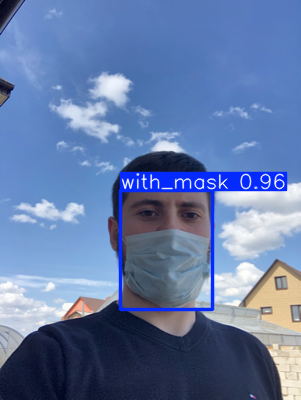

In [28]:
metrics = model.val()

# Perform object detection on an image
results = model("/kaggle/input/face-mask-detection/images/maksssksksss107.png")
results[0].show()

# Evaluate our model

In [29]:
metrics = model.val(split='val')

print(f"Mean Average Precision  : {metrics.box.map}")    
print(f"Mean Average Precision   : {metrics.box.map50}") 
print(f"Mean Average Precision    : {metrics.box.map75}")
print("recall : ",metrics.box.r)
print(metrics.box.f1)
print(metrics.box.maps)

metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

metrics_df.round(3)

Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/working/data_image/test.cache... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 171/171 [00:00<00:00, 186.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]


                   all        171        840      0.884      0.712      0.796      0.526
             with_mask        158        677      0.946      0.889      0.948      0.658
 mask_weared_incorrect         13         20      0.883        0.5      0.613      0.404
          without_mask         56        143      0.822      0.748      0.827      0.515


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.1ms preprocess, 7.2ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train3
Mean Average Precision  : 0.5258330765372566
Mean Average Precision   : 0.795796624069579
Mean Average Precision    : 0.5950805873731463
recall :  [    0.88922         0.5     0.74825]
[    0.91676     0.63859     0.78326]
[     0.6581     0.40435     0.51505]


Metric Value
metrics/precision(B)         0.884
metrics/recall(B)            0.712
metrics/mAP50(B)             0.796
metrics/mAP50-95(B)          0.526
fitness                      0.553

(-0.5, 2249.5, 1499.5, -0.5)

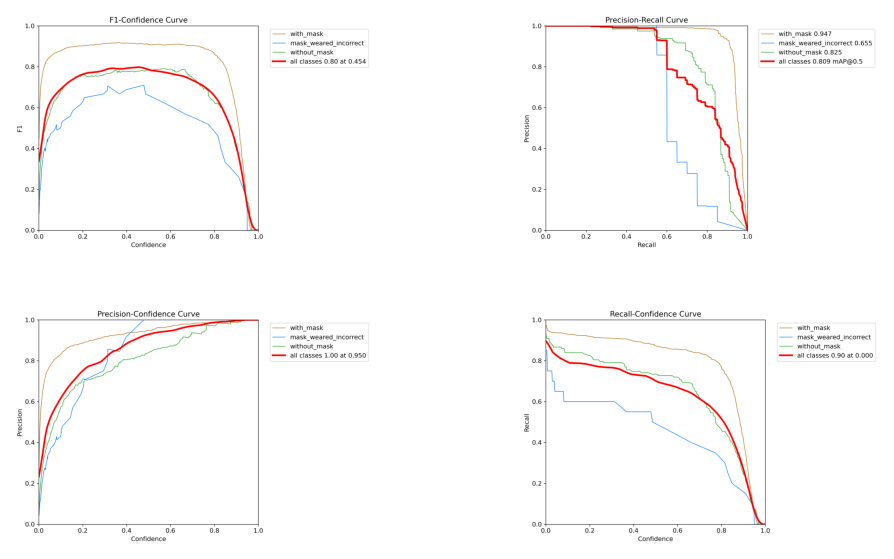

In [30]:
plt.figure(figsize=(12,7))

plt.subplot(221)
F1_curve = cv2.imread('/kaggle/working/runs/detect/train/F1_curve.png')
plt.imshow(F1_curve)
plt.axis('off')
plt.subplot(222)
PR_curve = cv2.imread('/kaggle/working/runs/detect/train/PR_curve.png')
plt.imshow(PR_curve)
plt.axis('off')
plt.subplot(223)
P_curve = cv2.imread('/kaggle/working/runs/detect/train/P_curve.png')
plt.imshow(P_curve)
plt.axis('off')
plt.subplot(224)
R_curve = cv2.imread('/kaggle/working/runs/detect/train/R_curve.png')
plt.imshow(R_curve)
plt.axis('off')

(-0.5, 2399.5, 1199.5, -0.5)

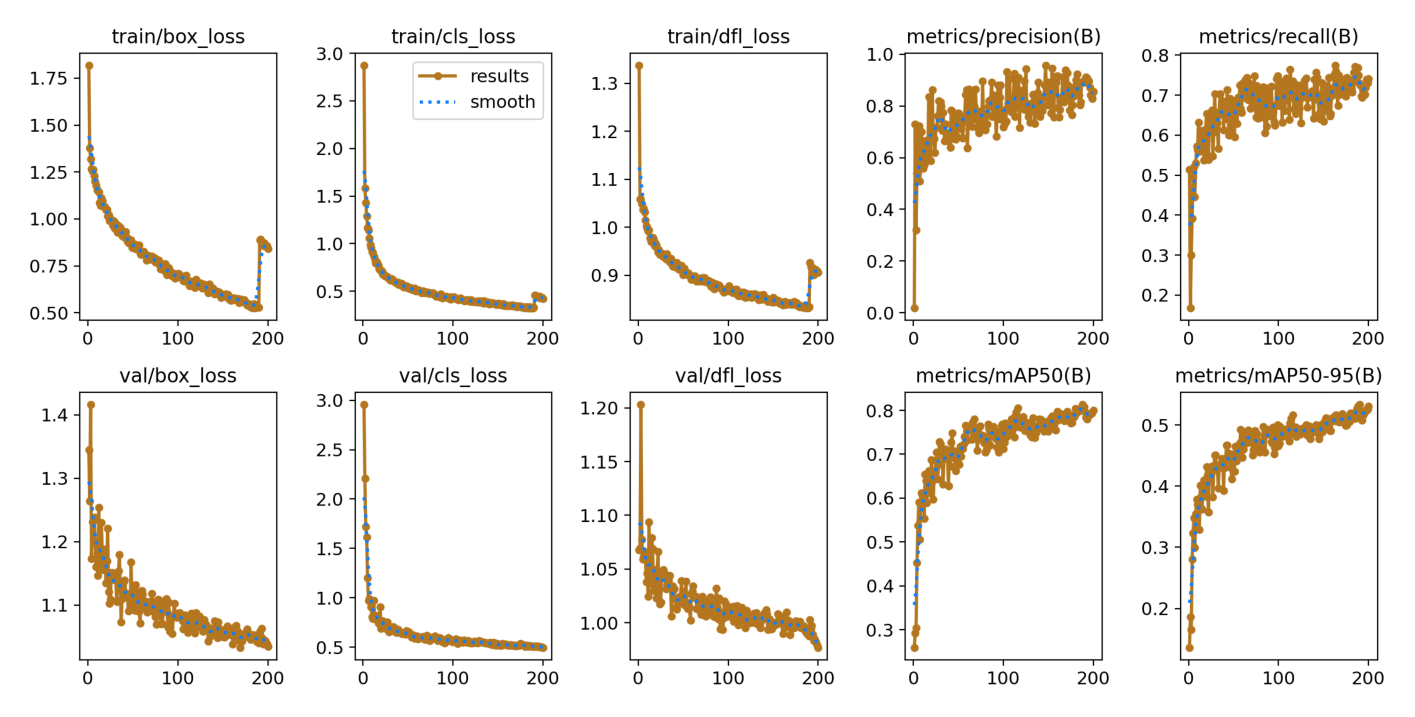

In [31]:
plt.figure(figsize=(18,18))
img = cv2.imread('/kaggle/working/runs/detect/train/results.png')
plt.imshow(img)
plt.axis('off')

(-0.5, 2999.5, 2249.5, -0.5)

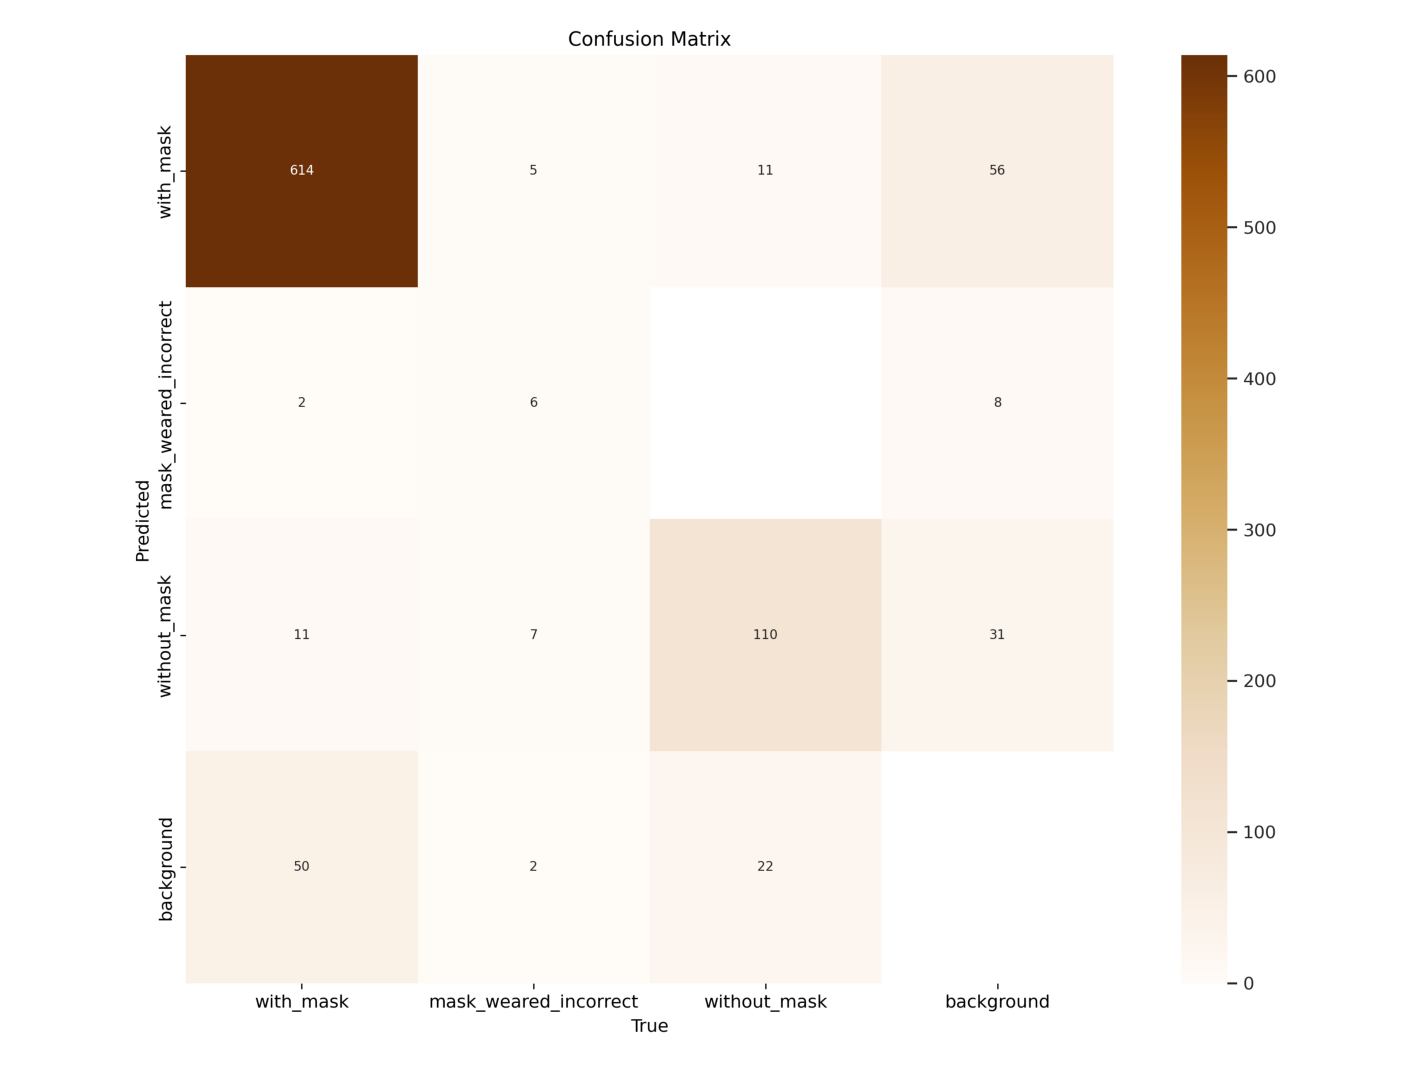

In [32]:
plt.figure(figsize=(18,18))
confusion_matrix = cv2.imread('/kaggle/working/runs/detect/train/confusion_matrix.png')
plt.imshow(confusion_matrix)
plt.axis('off')

(-0.5, 1919.5, 1279.5, -0.5)

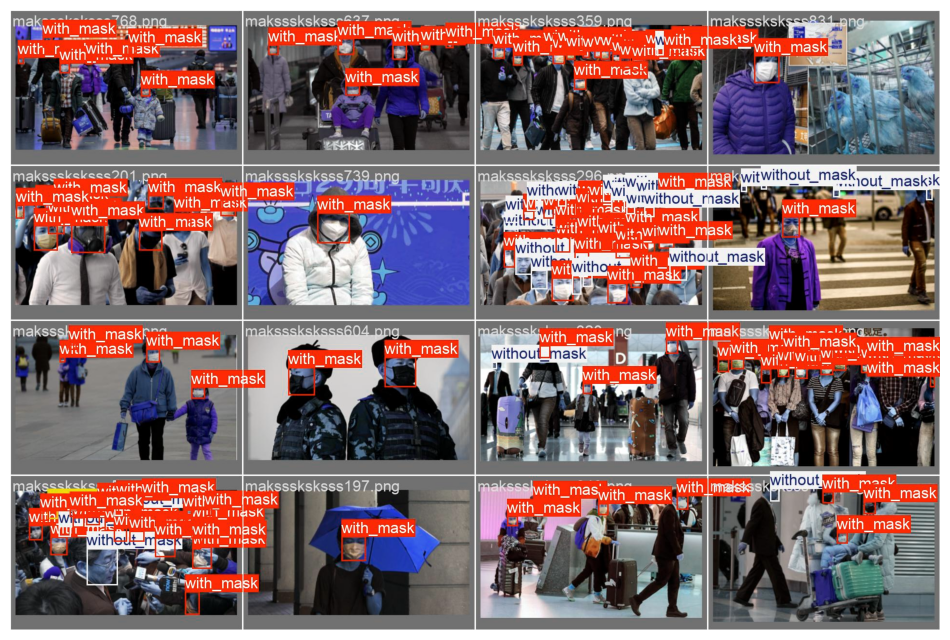

In [33]:
plt.figure(figsize=(12,12))
image = cv2.imread('/kaggle/working/runs/detect/train/val_batch1_labels.jpg')
plt.imshow(image)
plt.axis('off')

# Use our best model

In [34]:
best_model='/kaggle/working/runs/detect/train/weights/best.pt'
model=YOLO(best_model)


image 1/1 /kaggle/working/data_image/test/maksssksksss245.png: 352x640 8 with_masks, 43.2ms
Speed: 1.5ms preprocess, 43.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


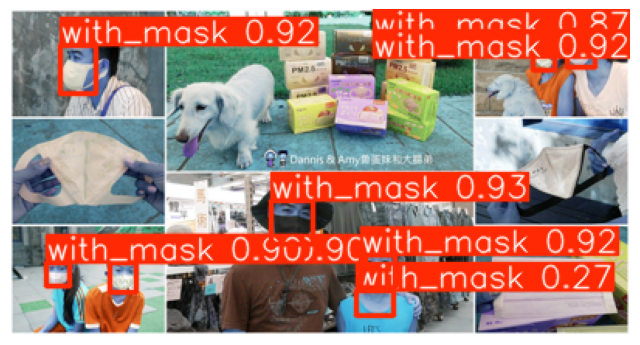


image 1/1 /kaggle/working/data_image/test/maksssksksss637.png: 384x640 6 with_masks, 43.1ms
Speed: 1.6ms preprocess, 43.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


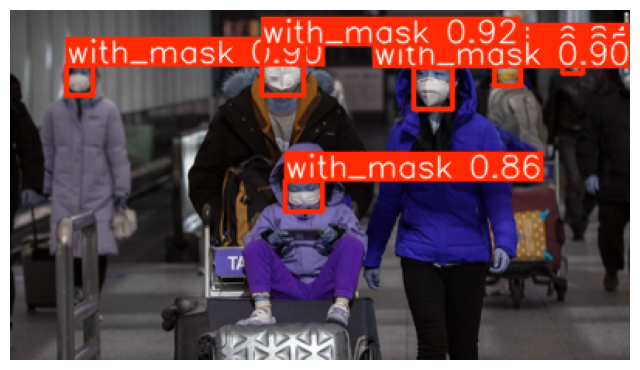


image 1/1 /kaggle/working/data_image/test/maksssksksss344.png: 384x640 4 with_masks, 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


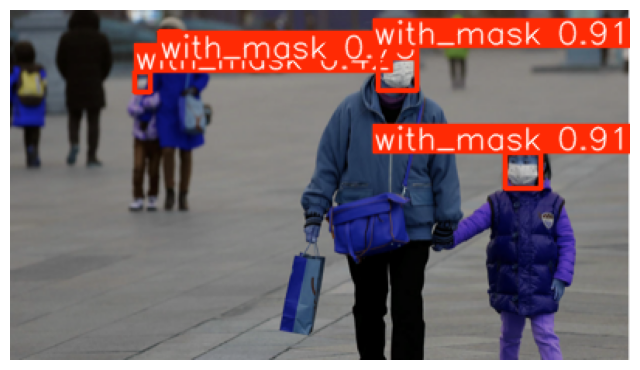


image 1/1 /kaggle/working/data_image/test/maksssksksss133.png: 640x512 1 with_mask, 10.6ms
Speed: 2.4ms preprocess, 10.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


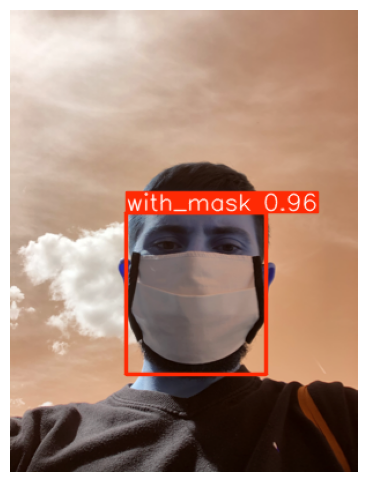


image 1/1 /kaggle/working/data_image/test/maksssksksss604.png: 384x640 2 with_masks, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


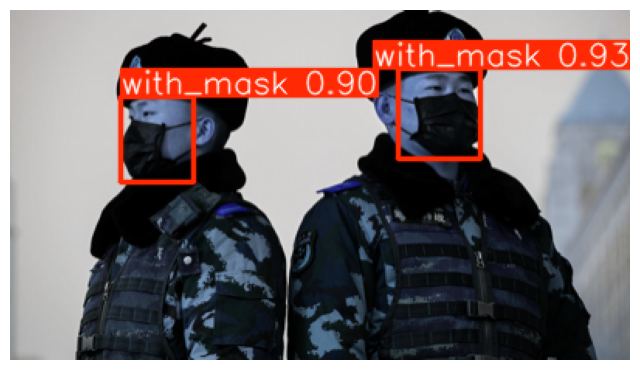


image 1/1 /kaggle/working/data_image/test/maksssksksss332.png: 640x512 1 with_mask, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


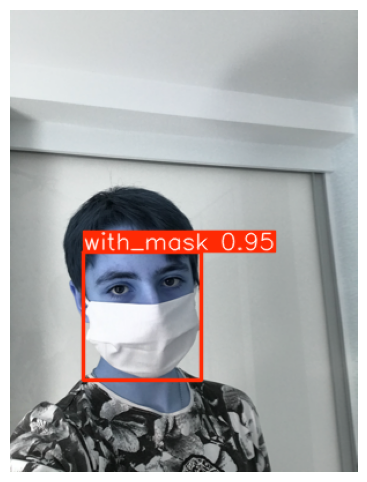


image 1/1 /kaggle/working/data_image/test/maksssksksss844.png: 384x640 2 with_masks, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


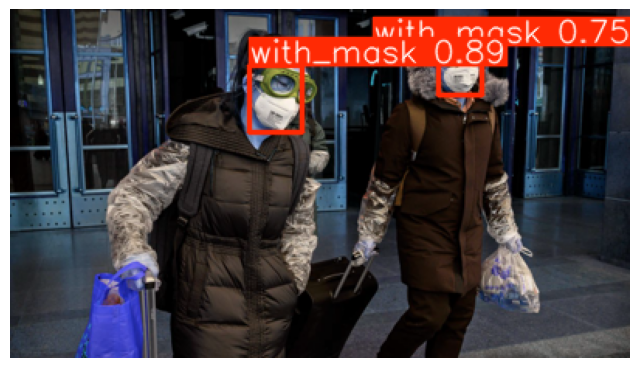


image 1/1 /kaggle/working/data_image/test/maksssksksss605.png: 640x448 1 with_mask, 43.2ms
Speed: 1.8ms preprocess, 43.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


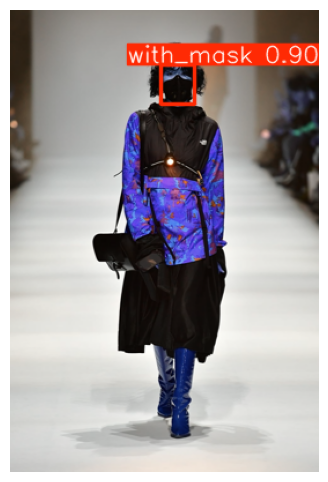


image 1/1 /kaggle/working/data_image/test/maksssksksss251.png: 352x640 20 with_masks, 1 without_mask, 9.7ms
Speed: 1.5ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


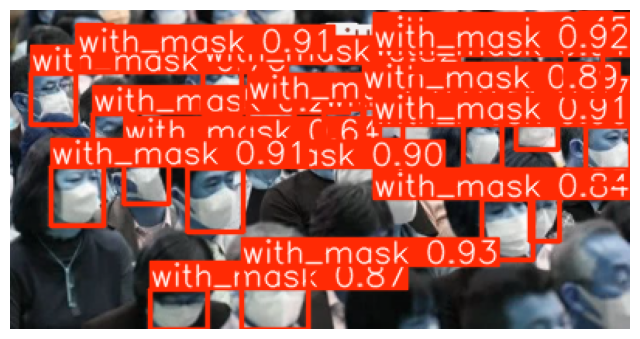


image 1/1 /kaggle/working/data_image/test/maksssksksss830.png: 640x448 1 mask_weared_incorrect, 9.4ms
Speed: 2.2ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


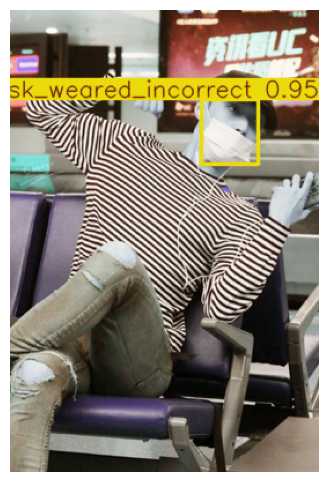

In [35]:
#visualiser les predictions 
image_dir = glob("/kaggle/working/data_image/test/*.png")

selected_images = image_dir[:10]


for img_path in selected_images:
 
    results = model.predict(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    for result in results:
        plotted_img = result.plot()
        plt.figure(figsize=(8, 6))  
        plt.imshow(plotted_img)    
        plt.axis('off')             
        plt.show() 